# Classification of Cuisines using Recipe Ingredients - Data Wrangling

Food is a massive and complex arena in which culture, geography, climate, and social factors combine to create unique cuisines around the world. With the age of the internet, millions of recipes are now shared instantly and easily accessible. Many ingredients previously specific to certain regions of the world are now also widely available due to online commerce. This project aims to identify the signatures of particular cuisines.

### Objectives

1. Load the data and extract general info and structure
2. Deal with outlier values in recipe ingredients
3. Export cleaned version of dataset for further exploration and analysis

#### Import necessary packages and data

In [284]:
# Packages to read and work with data
import json
import pandas as pd
import numpy as np

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

# Handling of text data
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from collections import defaultdict

# for timing code to assess performance
import time

#### Load original dataset

In [341]:
data = pd.read_json("data/train.json")

In [342]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
cuisine        39774 non-null object
id             39774 non-null int64
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [242]:
# Count how many duplicate rows appear in the dataset
data.duplicated(subset='id').sum()

0

We can see that the data is relatively clean, and apparently free of duplicate entries. We can now check what each entry of the data looks like.

In [243]:
# Preview first few rows of data
data.head(10)

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."
5,jamaican,6602,"[plain flour, sugar, butter, eggs, fresh ginge..."
6,spanish,42779,"[olive oil, salt, medium shrimp, pepper, garli..."
7,italian,3735,"[sugar, pistachio nuts, white almond bark, flo..."
8,mexican,16903,"[olive oil, purple onion, fresh pineapple, por..."
9,italian,12734,"[chopped tomatoes, fresh basil, garlic, extra-..."


There are three columns presented above. 'Cuisine' indicates the category of cuisine for a particular recipe, while 'ingredients' contains a list of ingredients for the respective entry. In addition, every entry has a unique recipe ID, which is listed in the 'id' column.

The main columns of interest here are the cuisine and ingredients categories. To begin, we should inspect the contents of each. Below is a list of all cuisine categories that appear in the dataset.

Cuisine Categories in the dataset (by occurence):
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

There are 20 cuisine categories represented in this dataset.


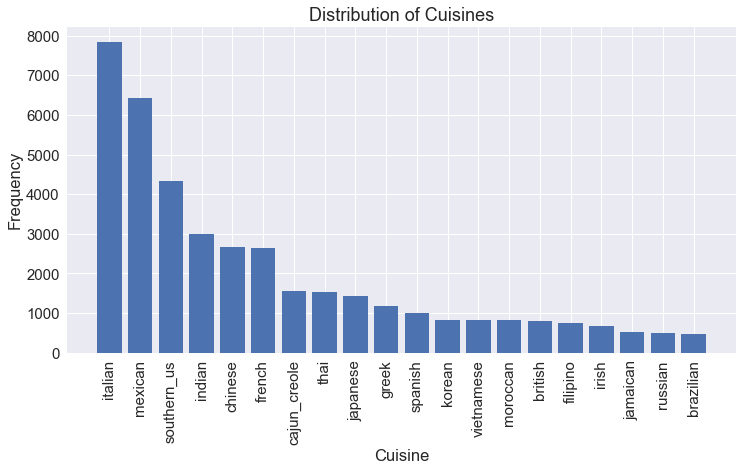

In [7]:
# Display the list of cuisines that appear in the dataset
print('Cuisine Categories in the dataset (by occurence):')
print(data.cuisine.value_counts())

print('\nThere are {0} cuisine categories represented in this dataset.'.format(data.cuisine.value_counts().shape[0]))

# plot distribution of cuisine categories
plt.subplots(figsize=(12, 6))
plt.bar(range(len(data.cuisine.value_counts().index)), data.cuisine.value_counts())
plt.title('Distribution of Cuisines')
plt.xlabel('Cuisine')
plt.ylabel('Frequency')
plt.xticks(range(len(data.cuisine.value_counts().index)), data.cuisine.value_counts().index, rotation='vertical')

plt.show()

We can see that some categories, such as Italian and Mexican Cuisines occupy much larger fractions of the data, but overall there aren't any cuisines with overly small amounts of recipes represented here.

Next we will take a look at the ingredient details. First, we will look at the statistics of overall length of the ingredients list for each entry.

count    39774.000000
mean        10.767713
std          4.428978
min          1.000000
25%          8.000000
50%         10.000000
75%         13.000000
max         65.000000
dtype: float64

 Median Value: 10.0


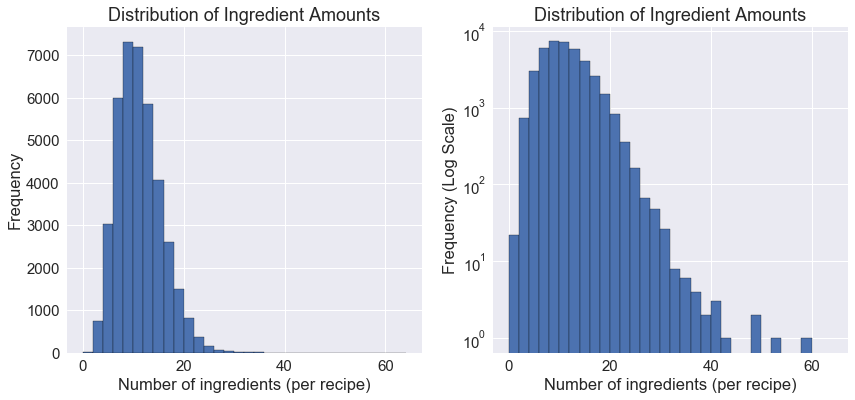

In [8]:
# Create a list of lengths of ingredients for each recipe
ingredients_len = []
for i in range(data.shape[0]):
    ingredients_len.append(len(data.ingredients[i]))

ingredients_len = pd.Series(ingredients_len)

# Display statistics of lengths of ingredients
print(ingredients_len.describe())
print('\n Median Value: {0}'.format(ingredients_len.median()))

plt.subplots(figsize=(14,6))
bins = range(0, 66, 2)

plt.subplot(1, 2, 1)
ingredients_len.hist(edgecolor='k', bins=bins)
plt.ylabel('Frequency')
plt.xlabel('Number of ingredients (per recipe)')
plt.title('Distribution of Ingredient Amounts')

plt.subplot(1, 2, 2)
ingredients_len.hist(edgecolor='k', bins=bins)
plt.yscale('log')
plt.ylabel('Frequency (Log Scale)')
plt.xlabel('Number of ingredients (per recipe)')
plt.title('Distribution of Ingredient Amounts')

plt.show()

There is quite a large variation in the number of ingredients per recipe, with a maximum of 65 in this dataset. The average tends to be about 10 ingredients per recipe. Surprisingly, there are recipes with only 1 ingredient! We can see the ingredients for these below.

In [9]:
# Display cuisine and ingredient lists for recipes with only 1 ingredient
for i in range(data.shape[0]):
    if len(data.ingredients[i]) == 1:
        print(data.cuisine[i], data.ingredients[i])

japanese ['sushi rice']
vietnamese ['dried rice noodles']
indian ['plain low-fat yogurt']
indian ['unsalted butter']
japanese ['udon']
thai ['sticky rice']
indian ['butter']
mexican ['corn tortillas']
thai ['grained']
southern_us ['lemonade concentrate']
thai ['jasmine rice']
indian ['unsalted butter']
italian ['cherry tomatoes']
french ['butter']
indian ['cumin seed']
french ['haricots verts']
mexican ['vegetable oil']
spanish ['spanish chorizo']
spanish ['sweetened condensed milk']
japanese ['water']
greek ['phyllo']
indian ['unsalted butter']


Now we can look at some more details of the ingredients we are working with. We will look at the total list of all ingredients in the data.

In [10]:
# Create a set for holding only unique ingredients
ingredients_set = set()

# Create a list for holding all ingredients
ingredients_combined = []

# Populate set and list
for i in range(data.shape[0]):
    ingredients_set.update(data.ingredients[i])
    ingredients_combined.extend(data.ingredients[i])

# Create a ranking of most common ingredients
ingredient_rankings = pd.Series(ingredients_combined).value_counts()
    
# Display information about the ingredients
print('Number of unique ingredients in the dataset: {0}'.format(len(ingredients_set)))
print('Number of total ingredients in the dataset: {0}'.format(len(ingredients_combined)))
print('\nIngredients ranked by occurence in the data:')
print(ingredient_rankings)

Number of unique ingredients in the dataset: 6714
Number of total ingredients in the dataset: 428275

Ingredients ranked by occurence in the data:
salt                                          18049
onions                                         7972
olive oil                                      7972
water                                          7457
garlic                                         7380
sugar                                          6434
garlic cloves                                  6237
butter                                         4848
ground black pepper                            4785
all-purpose flour                              4632
pepper                                         4438
vegetable oil                                  4385
eggs                                           3388
soy sauce                                      3296
kosher salt                                    3113
green onions                                   3078
tomatoes             

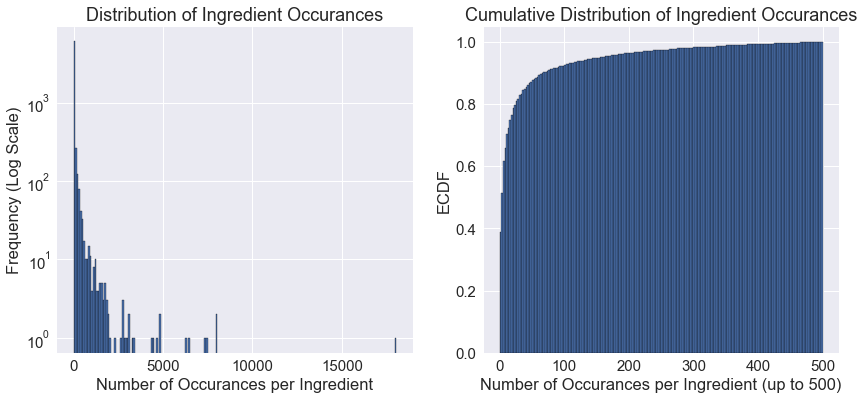

In [11]:
# Plot total distribution of ingredient occurences
plt.subplots(figsize=(14,6))
plt.subplot(1, 2, 1)
ingredient_rankings.hist(bins=200, edgecolor='k')
plt.xlabel('Number of Occurances per Ingredient')
plt.ylabel('Frequency (Log Scale)')
plt.yscale('log')
plt.title('Distribution of Ingredient Occurances')

# Plot ECDF of ingredient occurences
plt.subplot(1, 2, 2)
ingredient_rankings.hist(bins=200, edgecolor='k', cumulative=True, normed=True, range=[0,500])
plt.xlabel('Number of Occurances per Ingredient (up to 500)')
plt.ylabel('ECDF')
plt.title('Cumulative Distribution of Ingredient Occurances')

plt.show()

We can see that while salt is almost ubiquitous, less than half of our ingredients show up more than a few times each. This will need to be addressed, since it may make building a predictive model very difficult. One reason for this is that many similar ingredients have many variants, as is shown below for ingredients containing "Turkey".

In [12]:
total_turkeys = 0
i = 0
for ingredient in ingredients_set:
    if re.search(r"turkey", ingredient):
        total_turkeys += ingredient_rankings.loc[ingredient]
        print('{0}: {1}'.format(ingredient, ingredient_rankings.loc[ingredient]))
        i +=1
print('Number of Turkey variations: {0}'.format(i))
print('Total times ingredients with Turkey were used: {0}'.format(total_turkeys))

turkey breast steaks: 1
turkey salami: 1
turkey ham: 1
sliced turkey: 6
lean ground turkey: 26
rich turkey stock: 1
hot italian turkey sausage: 2
boneless turkey breast: 3
ground turkey sausage: 1
turkey tenderloins: 11
smoked turkey breast: 5
turkey carcass: 2
turkey burger: 1
low fat mild Italian turkey sausage: 1
Italian turkey sausage: 54
turkey sausage links: 3
turkey meatballs: 1
turkey kielbasa: 18
turkey gravy: 1
sweet turkey sausage: 1
whole turkey: 1
turkey giblet stock: 1
turkey thigh: 2
ground turkey breast: 39
smoked turkey: 16
ground turkey: 168
cooked turkey: 48
Italian turkey sausage links: 2
turkey breast deli meat: 2
roast turkey: 10
turkey: 62
dark turkey meat: 1
turkey sausage: 15
turkey hot dogs: 1
smoked turkey drumstick: 1
turkey breast tenderloins: 2
fat free ground turkey breast: 1
turkey mince: 1
turkey legs: 9
seasoned ground turkey: 1
low-fat turkey kielbasa: 1
turkey stock: 9
turkey bacon: 12
boneless skinless turkey breasts: 1
turkey breast cutlets: 10
hot

We can see that although turkey appears more than 600 times in the dataset, there are over 50 variants of turkey in the ingredient set, and most are only present a few times. In addition, we cannot simply set all variants to be labeled as "Turkey" since some, such as turkey stock are only flavorings and do not include any of the original turkey meat.

In order to deal with these variants, several (or many) steps will need to be taken.

## Part 2. Dealing with outliers (the messy part)

The next section will be a bit messy with many iterations in place to converge on a final set of ingredients. Hopefully my explanations will make a clear throughline to follow. First, I will take each ingredient from our ingredient_rankings (which is an ordered form of our unique ingredients set) and extract only the nouns. This means that 'chopped ingredient', 'fresh ingredient', 'baked ingredient' etc. will be converted to 'ingredient'. We will call these ingredients "simplified", although they are only the first draft of our ingredients list.

I will also take only the singular form of each ingredient, so that there aren't unnecessary duplicates (e.g. 'onions' and 'onion')

Note: some words don't play nicely with NLTK's database of vocabulary (such as 'garlic', which tends to be classified as an adjective. e.g. 'garlic cloves' is simplified as 'clove') so I will include two lists of words for this process that will be updated throughout this section. They are **'words_to_exclude'** for words I do not want in my final list, and **'words_to_include'** for words that I do not want filtered out.

In [13]:
# Initialize a lemmatizer to produce the singular forms of nouns
wnl = WordNetLemmatizer()

# Initialize list for simple ingredient labels
simple_ingredients = []

# Identify words that wordnet has difficulty with to make sure they are excluded or not excluded from the ingredients
words_to_exclude = set(['sodium', 'ground', 'boneless', 'skinless', 'kosher', '%', 'cloves'])
words_to_include = set(['sour', 'garlic', 'pepper', 'olive', 'vegetable'])

# Print a header for list of ingredients that yield no simplified form
print('List of ingredients with no simplified form found:')

# Loop through 
for ingredient in ingredient_rankings.index:
    # tokenize ingredient
    ing_tokenized = word_tokenize(ingredient.lower())
    
    # Remove verbs (makes noun processing a little easier)
    no_verbs = [word for (word, pos) in pos_tag(ing_tokenized, tagset='universal') if pos!='VERB' and word not in words_to_exclude or (word in words_to_include)]
    
    # Extract singular form of nouns left in the ingredient
    nouns = [wnl.lemmatize(word) for (word, pos) in pos_tag(no_verbs, tagset='universal') if pos=='NOUN' or word in words_to_include]
    
    # If the string is empty, print the ingredient
    if len(nouns) == 0:
        print(ingredient)
    
    # Add to simple ingredients list
    simple_ingredients.append(' '.join(nouns))

List of ingredients with no simplified form found:
shortening
self rising flour
couscous
plain flour
seasoning
gruyere cheese
dressing
whipped topping
flavoring
jelly
frosting
stuffing
riesling
fully cooked ham
red
shaoxing
curly endive
icing
self raising flour
black
pearl couscous
blackening seasoning
flaked
ground flaxseed
7 Up
pudding
knockwurst
mezcal
topping
grained
endive
instant couscous
knoblauch
any
smoked fully cooked ham
filling
other
fingerling
japanese radish
33% less sodium smoked fully cooked ham
blacan
asian
long green
uni
extra
kingfish
belacan
fiber one
Sangiovese
fat free whipped topping
swiss
chinese radish


Ok we can see from above that some ingredients in our dataset are either misspelled or incomplete in some way (e.g. 'any', 'extra', 'asian') we can deal with misspellings later, but first, we should make sure that some of the words that are falling through the cracks do not, such as 'flour', 'couscous', 'pudding', etc.

In [14]:
# Add terms to words_to_include
words_to_include.update(['shortening', 'flour', 'couscous', 'seasoning', 'cheese', 'dressing', 'radish', 'jelly', 'stuffing', 'ham', 'flaxseed', 'pudding', 'icing', 'frosting', 'topping'])

# Make second draft of simplified ingredients
simple_ingredients2 = []

# Print a header for list of ingredients that yield no simplified form
print('List of ingredients with no simplified form found:')

# Loop through 
for ingredient in ingredient_rankings.index:
    # tokenize ingredient
    ing_tokenized = word_tokenize(ingredient.lower())
    
    # Remove verbs (makes noun processing a little easier)
    no_verbs = [word for (word, pos) in pos_tag(ing_tokenized, tagset='universal') if pos!='VERB' and word not in words_to_exclude or (word in words_to_include)]
    
    # Extract singular form of nouns left in the ingredient
    nouns = [wnl.lemmatize(word) for (word, pos) in pos_tag(no_verbs, tagset='universal') if pos=='NOUN' or word in words_to_include]
    
    # If the string is empty, print the ingredient and set the simplified ingredient to 'other'
    if len(nouns) == 0:
        print(ingredient)
        simple_ingredients2.append('other')
    else:
        # Add to simple ingredients list
        simple_ingredients2.append(' '.join(nouns))

List of ingredients with no simplified form found:
flavoring
riesling
red
shaoxing
curly endive
black
flaked
7 Up
knockwurst
mezcal
grained
endive
knoblauch
any
filling
other
fingerling
blacan
asian
long green
uni
extra
kingfish
belacan
fiber one
Sangiovese
swiss


This list is much more acceptable than the previous, so all of the ingredients above have been simplified as 'other'. Now we can do a quick check on the progress to see how many ingredients we are left with.

In [16]:
# Create a dataframe to preview changes in ingredients
compare_ingredients_test = pd.DataFrame(data={'original ingredients': ingredient_rankings.index, 'simplified': simple_ingredients2})
print(compare_ingredients_test[:30])

# Print out reduction in unique ingredients
print('\nAfter 1st Step: Unique ingredients reduced from {0} to {1}'.format(compare_ingredients_test.shape[0], len(set(compare_ingredients_test.simplified))))

      original ingredients     simplified
0                     salt           salt
1                   onions          onion
2                olive oil      olive oil
3                    water          water
4                   garlic         garlic
5                    sugar          sugar
6            garlic cloves   garlic clove
7                   butter         butter
8      ground black pepper         pepper
9        all-purpose flour          flour
10                  pepper         pepper
11           vegetable oil  vegetable oil
12                    eggs            egg
13               soy sauce      soy sauce
14             kosher salt           salt
15            green onions          onion
16                tomatoes         tomato
17              large eggs            egg
18                 carrots         carrot
19         unsalted butter         butter
20            ground cumin          cumin
21  extra-virgin olive oil      olive oil
22            black pepper        

Ok! So we've dropped about 2,200 ingredients (1/3 of our original set!), but there is still a long way to go. Next, we should check to see if there are any spelling errors causing variations in our ingredient set.

In [18]:
# Create a new list of ingredients to iterate and search through
simple_ingredient_rankings2 = compare_ingredients_test.simplified.value_counts().index

for ingredient in simple_ingredient_rankings2:
    tokenized = word_tokenize(ingredient)
    misspellings = [word for word in tokenized if not wordnet.synsets(word)]
    if len(misspellings) > 0:
        print(misspellings, ingredient, ingredients_combined.count(ingredient))

['quinoa'] quinoa 116
['nori'] nori 96
['chilies'] chilies 0
['chees'] chees 0
['udon'] udon 48
['ramen'] ramen 8
['marzano'] marzano tomato 0
['demi-glace'] demi-glace 5
['romano'] romano cheese 106
['arbol'] arbol chile 10
['provolone'] provolone cheese 165
['kielbasa'] kielbasa 28
['prosecco'] prosecco 12
['kielbasa'] turkey kielbasa 18
['poblano'] poblano 15
['pappardelle'] pappardelle 11
['rosã©'] rosã© 0
['fava'] fava bean 0
['edamame'] edamame bean 0
['dillweed'] dillweed 2
['foie', 'gras'] foie gras 12
['garam', 'masala'] garam masala 925
['stonefire'] stonefire pizza crust 0
['cornflakes'] cornflakes 5
['basmati'] basmati rice 326
['smithfield'] smithfield ham 1
['knorr'] knorr chicken flavor bouillon 8
['pepitas'] pepitas 21
['lipton'] lipton tea bag 0
['medjool'] medjool date 23
['peperoncini'] peperoncini 8
['marrons'] marrons 1
['kalamata'] kalamata olive 0
['cointreau'] cointreau liqueur 2
['poblano'] poblano pepper 0
['muscovado'] muscovado sugar 21
['mahi', 'mahi'] mahi

['kasu'] kasu 2
['callaloo'] callaloo 9
['challa'] challa 6
['borlotti'] borlotti 1
['fresca'] fresca 9
["hellmann'sâ®"] hellmann'sâ® mayonnaise 0
['qua'] mo qua 0
['comino'] comino 2
['channa'] channa dal 9
['daiya'] daiya 0
['oliv'] oliv pit ripe 3
['besan'] besan flour 0
['kochujang'] kochujang 7
['boquerones'] boquerones 1
['queso', 'fresca'] queso fresca 2
['poppyseeds'] poppyseeds 1
['lo', 'bok'] lo bok 1
['karo'] karo corn syrup 0
['tzatziki'] tzatziki 17
['aonori'] aonori 2
['yaki-nori'] yaki-nori 2
['crisco'] crisco 7
['krispies'] rice krispies 0
['khoa'] khoa 9
['empanada'] empanada wrapper 0
['limoncello'] limoncello 6
['nuoc', 'nam'] nuoc nam 5
['graviera'] graviera 1
['hillshire'] hillshire farm sausage 0
['jif'] jif creamy butter 0
['ogura-an'] ogura-an 1
['korma'] korma paste 2
['sazon'] sazon goya 1
['clamato'] clamato juice 3
['cavenders'] cavenders seasoning 0
['pancetta'] pancetta slice 0
['tempeh'] tempeh 17
['herdez', 'verde'] herdez salsa verde 0
['lambic'] raspbe

['branzino'] branzino fillet 0
['herbes'] herbes provence 0
['parmigiano', 'reggiano'] parmigiano reggiano cheese 353
['proscuitto', 'di', 'parma'] proscuitto di parma 1
['crostini'] crostini 6
['halloumi'] halloumi cheese 3
['papad'] papad 4
['chayotes'] chayotes 32
['opo'] opo squash 1
['shirataki'] shirataki 9
['noir'] pinot noir 8
['banh', 'hoi'] banh hoi 1
['habanero'] chili habanero pepper 2
['prego'] prego mushroom sauce 0
['chia'] chia seed 0
['rotel'] pasta rotel 2
['mirlitons'] mirlitons 10
['lipton', 'recip'] lipton recip onion soup mix 0
['martha'] martha mix 0
['xanthan'] xanthan gum 20
['ciabatta'] bread ciabatta 21
['teleme'] teleme 2
['crimini'] crimini mushroom 0
['amaretti'] amaretti 7
['chana'] chana dal 23
['vinaigrett'] bone wine vinaigrett dress 0
['nondairy'] nondairy topping 0
['mooli'] mooli 1
['wheatberries'] wheatberries 2
['morcilla'] morcilla 1
['tatsoi'] baby tatsoi 2
['roti'] roti 2
['manischewitz'] manischewitz matzo meal 0
['abura'] abura age 4
['chees'

There is quite a bit to unpack here. First, we have words originating from other languages such as *'edamame'* and *'arborio'*. We will have to be careful how we choose to deal with these words.

We also have some words that are brand-related, such as *'lipton'*, *'smithfield'* and *'knorr'*.

Finally, in addition to the normal misspellings (e.g. *cheesi* instead of cheese or cheesy) there are many misspelling entries that have special characters, such as *'johnsonvilleâ®'* and *'crã¨me fraã®che'*. These are the easiest to deal with since we can simply remove all words that are not strictly composed of alphabetic characters.

In [19]:
# Create a third list of simplified ingredients
simple_ingredients3 = []

# Iterate through list of ingredients and find all entries that contain characters other than alphabetic
for ingredient in simple_ingredient_rankings2:
    tokenized = word_tokenize(ingredient)
    other_chars = [word for word in tokenized if not word.isalpha() and not re.search(r"[-\.]", word)]
    
    if len(other_chars) > 0:
        print(ingredient, other_chars)
        alpha_ingredient = [word for word in tokenized if word not in other_chars]
        if len(alpha_ingredient) == 0:
            simple_ingredients3.append('other')
        else:
            simple_ingredients3.append(' '.join(alpha_ingredient))
    else:
        simple_ingredients3.append(ingredient)

rosã© ['rosã©']
crã¨me fraã®che ['crã¨me', 'fraã®che']
curaã§ao ['curaã§ao']
tamarind purã©e ['purã©e']
liptonâ® recipe secretsâ® onion soup mix ['liptonâ®', 'secretsâ®']
el pasoâ„¢ bean ['pasoâ„¢']
bertolliâ® alfredo sauce ['bertolliâ®']
el pasoâ„¢ seasoning mix ['pasoâ„¢']
chestnut purã©e ['purã©e']
raguâ® robusto â® pasta sauce ['raguâ®', 'â®']
neufchã¢tel ['neufchã¢tel']
sheepâ€™s milk cheese ['sheepâ€™s']
piment d'espelette ["d'espelette"]
gruyã¨re cheese ['gruyã¨re']
bertolliâ® classico olive oil ['bertolliâ®']
johnsonvilleâ® mild sausage ['johnsonvilleâ®']
diamond crystalâ® salt ['crystalâ®']
aã§ai powder ['aã§ai']
valleyâ® ranchâ® light dressing ['valleyâ®', 'ranchâ®']
johnsonvilleâ® spicy brat ['johnsonvilleâ®']
oreoâ® cooky ['oreoâ®']
jonshonvilleâ® cajun style sausage ['jonshonvilleâ®']
pillsburyâ„¢ pizza crust ['pillsburyâ„¢']
niã§oise olive ['niã§oise']
hellmann'sâ® mayonnaise ["hellmann'sâ®"]
yoplaitâ® caramel yogurt ['yoplaitâ®']
za'atar ["za'atar"]
el pasoâ„¢ thick chun

In [226]:
print('Number of ingredients left so far: {0}'.format(len(set(simple_ingredients3))))

Number of ingredients left so far: 4404


Although we haven't reduced the number of ingredients much this time around, the dataset is cleaner now that the non-alphabetic words have been removed.

Next we will remove the brand-related words by adding them into the 'words_to_exclude' list.

In [227]:
words_to_exclude.update(['marzano', 'pace', 'arbol', 'cointreau', 'knorr', 'lipton', 'panko', 'smithfield', 'kikkoman',
                         'jameson', 'stonefire', 'pickapeppa', 'chambord', 'conimex', 'ro-tel', 'bertolli', 'classico',
                         'ragu', 'bisquick', 'branston', 'johnsonville', 'hogue', 'rotel', 'oscar', 'mayer',
                         'broiler-fryer', 'meyer', 'barilla', 'herdez', 'pam', 'el', 'paso', 'panela', 'hellman',
                         'hellmann', 'tony', 'zatarains', 'jarlsberg', 'pasilla', 'prego', 'low-fat', 'manischewitz',
                         'robert', 'mondavi', 'eggland', 'budweiser', 'wish-bone', 'progresso', 'kraft', 'bone-in',
                         'pillsbury', 'country', 'crock', 'yoplait', 'stonefire', 'jarlsberg', 'lowfat', 'kikkoman',
                         'wondra', 'clamato', 'kroger', 'chinkiang', 'jif', 'multi-grain', 'jagermeister', 'prepar',
                         'goya', 'milkfat', 'nilla', 'crisco', 'lo', 'jose', 'cuervo', 'marnier', 'reduced-sodium', 'wesson', 'mazola'])

# 4th simplified ingredients list
simple_ingredients4 = []

# Loop through 
for ingredient in simple_ingredients3:
    # tokenize ingredient
    ing_tokenized = word_tokenize(ingredient.lower())
    
    # Remove verbs (makes noun processing a little easier)
    no_verbs = [word for (word, pos) in pos_tag(ing_tokenized, tagset='universal') if pos!='VERB' and word not in words_to_exclude or (word in words_to_include)]
    
    # Extract singular form of nouns left in the ingredient
    nouns = [wnl.lemmatize(word) for (word, pos) in pos_tag(no_verbs, tagset='universal') if pos=='NOUN' or word in words_to_include]
    
    # If the string is empty, print the ingredient and set the simplified ingredient to 'other'
    if len(nouns) == 0:
        simple_ingredients4.append('other')
    else:
        # Add to simple ingredients list
        simple_ingredients4.append(' '.join(nouns))
    
# display number of ingredients left after exclusion of brand-related terms
print('Number of ingredients left so far: {0}'.format(len(set(simple_ingredients4))))

Number of ingredients left so far: 4117


Next we will check the misspelled words left, along with their frequency in the list of ingredients.

In [229]:
# create a dictionary to store the number of times misspelling appears in the ingredients list
misspell_errors = defaultdict(int)

# Print header for output of loop
print('list of most common misspells in simle_ingredients4:')

for ingredient in simple_ingredients4:
    tokenized = word_tokenize(ingredient)
    for word in tokenized:
        if not wordnet.synsets(word):
            misspell_errors[word] += 1

# Display the rankings of misspelled/non-english words apppearing more than twice
for key, value in sorted(misspell_errors.items(),key=lambda v: v[1], reverse=True):
    if value > 3:
        print('{0}: {1}'.format(key, value))

list of most common misspells in simle_ingredients4:
sauc: 12
queso: 10
chilies: 8
chees: 7
masala: 7
alfredo: 7
tamari: 7
serrano: 6
dri: 6
habanero: 6
feta: 5
ciabatta: 5
choy: 5
rotini: 5
sazon: 5
nori: 4
poblano: 4
kalamata: 4
mahi: 4
soba: 4
creme: 4
bok: 4
colby: 4
annatto: 4
blanco: 4
leav: 4
dashi: 4
crema: 4
sauvignon: 4
verde: 4
empanada: 4
minicub: 4
splenda: 4


In [51]:
# Display number of misspellings found
print('Number of total misspellings occuring in simple_ingredients4: {0}'.format(len(list(sorted(misspell_errors.keys())))))

# Create a file to export list of misspelled items
misspell_file = open('data/misspells.txt', 'w')

# export list for quick spelling correction in google doc (a.k.a. the BEST spell checker)
misspell_file.write(', \n'.join(list(sorted(misspell_errors.keys()))))
print('misspell_errors list exported to .txt file!')

# close file
misspell_file.close()

Number of total misspellings occuring in simple_ingredients4: 701
misspell_errors list exported to .txt file!


Ok, there are a lot of entries in the misspelled ingredients. This presents a dilemma, since it's too long to go through by hand, and the strange nature of of many of the words not being strictly English makes them difficult to be interpreted correctly by a local spell-checker. No worries, Google's spell checker to the rescue! The workflow for this step is going to require some manual labor (until I find a way to do this within the script). The steps are as follows:

1. Export the list of misspellings to a txt file (completed above)
2. Import the list into a google doc manually
3. Use google doc spell checker to quickly run through and make corrections where possible
4. Export google doc as .txt file in the data folder ('data/misspells_corrected.txt')
5. Import .txt file into list and create a dictionary of misspelled words to corrected versions for quick replacement

Using Google's spell check, I was able to complete these steps in less than 5 minutes total, which is in my opinion an superb return on time efficiency for around 700 entries in multiple languages.

In [193]:
# import misspelling corrections .txt file into a list
misspell_c_file = open('data/misspells_corrected.txt', 'r', encoding='utf-8-sig')

# Load the file into a list
misspells_corrected = misspell_c_file.read().split(',\n')

# Remove extra characters introduced during loading
regex = re.compile('[^a-zA-Z\-\s]')
misspells_corrected = [regex.sub('', misspell) for misspell in misspells_corrected]

# Close file
misspell_c_file.close()

# Create a dictionary from original misspell file and corrections
misspell_dict = dict(zip(list(sorted(misspell_errors.keys())), misspells_corrected))

Now we can replace the misspelled entries with the corrected versions using the dictionary that has been built.

In [195]:
# Initialize 5th draft of simple ingredients list
simple_ingredients5 = []



# loop over each entry in simple_ingredients4
for ingredient in simple_ingredients4:
    tokenized = word_tokenize(ingredient)
    for word in tokenized:
        if word in misspell_errors.keys():
            ind = tokenized.index(word)
            tokenized.pop(ind) 
            tokenized[ind:ind] = word_tokenize(misspell_dict[word])

    # Remove verbs (makes noun processing a little easier)
    no_verbs = [word for (word, pos) in pos_tag(tokenized, tagset='universal') if pos!='VERB' and word not in words_to_exclude or (word in words_to_include)]
    
    # Extract singular form of nouns left in the ingredient
    nouns = [wnl.lemmatize(word) for (word, pos) in pos_tag(no_verbs, tagset='universal') if pos=='NOUN' or word in words_to_include]
    
    # If the string is empty, print the ingredient and set the simplified ingredient to 'other'
    if len(nouns) == 0:
        simple_ingredients5.append('other')
    else:
        # Add to simple ingredients list
        simple_ingredients5.append(' '.join(nouns))
    
# display number of ingredients left after exclusion of brand-related terms
print(len(set(simple_ingredients5)))

4053


Now that we have run through quite a few of our options in removing errors and combining ingredients via several methods, we see that we still have about 4,000 ingredients in our list (60% of our original ingredients!). But which of these are useful to our analysis? There are 2 methods that I will explore to build ingredients lists for exploratory analysis and training.

### Method 1: Use ingredients list and remove remaining outliers

We will first run our original ingredients set through a combined process of what has been done in this section, and check back in to see how many ingredients of these are used more than a few times in the complete dataset.

In [286]:
# Create a new dataset for simplified ingredients processing
data_simple = pd.DataFrame(data = {'cuisine': data.cuisine, 'ingredients': None})

In [287]:
# Loop through ingredients in each entry
for i in range(data.shape[0]):
    simple_ingredients_final = []
    for ingredient in data.ingredients[i]:
        # tokenize ingredient
        ing_tokenized = word_tokenize(ingredient.lower())

# STEP 1: Remove verbs, extract nouns and singularize
        # Remove verbs (makes noun processing a little easier)
        no_verbs = [word for (word, pos) in pos_tag(ing_tokenized, tagset='universal') if pos!='VERB' and word not in words_to_exclude or (word in words_to_include)]

        # Extract singular form of nouns left in the ingredient
        nouns = [wnl.lemmatize(word) for (word, pos) in pos_tag(no_verbs, tagset='universal') if pos=='NOUN' or word in words_to_include]

# STEP 2: Exclude words with special characters
        other_chars = [word for word in nouns if not word.isalpha() and not re.search(r"[-\.]", word)]
        alpha_ingredient = [word for word in nouns if word not in other_chars]

# STEP 3: Exclude misspelled words
        for word in alpha_ingredient:
                if word in misspell_errors.keys():
                    ind = alpha_ingredient.index(word)
                    alpha_ingredient.pop(ind) 
                    alpha_ingredient[ind:ind] = word_tokenize(misspell_dict[word])

        # Extract singular form of nouns left in the ingredients list
        nouns = [wnl.lemmatize(word) for (word, pos) in pos_tag(alpha_ingredient, tagset='universal') if pos=='NOUN' or word in words_to_include]

        # Add to ingredient list for current entry in the dataset
        if len(nouns) == 0:
            simple_ingredients_final.append('other')
        else:
            simple_ingredients_final.append(' '.join(nouns))

    data_simple.ingredients[i] = list(set(simple_ingredients_final))
    if i % 5000 == 0:
        print('{0} / {1} Ingredient Entries Simplified'.format(i, data.shape[0]))

# Notify when finished! (Takes ~14 minutes for full dataset)
print("-------Simplification Finished!----------")

0 / 39774 Ingredient Entries Simplified
5000 / 39774 Ingredient Entries Simplified
10000 / 39774 Ingredient Entries Simplified
15000 / 39774 Ingredient Entries Simplified
20000 / 39774 Ingredient Entries Simplified
25000 / 39774 Ingredient Entries Simplified
30000 / 39774 Ingredient Entries Simplified
35000 / 39774 Ingredient Entries Simplified
-------Simplification Finished!----------


In [306]:
# Display a preview of comparison between original and simplified ingredients
pd.DataFrame(data={'Original Ingredients': data.ingredients[:10], 'Simple Ingredients': data_simple.ingredients[:10]})

,Original Ingredients,Simple Ingredients
0,"[romaine lettuce, black olives, grape tomatoes...","[feta cheese crumbles, olive, grape tomato, on..."
1,"[plain flour, ground pepper, salt, tomatoes, g...","[corn meal, milk, thyme, flour, salt, tomato, ..."
2,"[eggs, pepper, salt, mayonaise, cooking oil, g...","[garlic powder, salt, cooking oil, onion, chic..."
3,"[water, vegetable oil, wheat, salt]","[water, salt, wheat, vegetable oil]"
4,"[black pepper, shallots, cornflour, cayenne pe...","[milk, bay leaf, shallot, chili powder, garlic..."
5,"[plain flour, sugar, butter, eggs, fresh ginge...","[milk, powder, flour, salt, cinnamon, ginger, ..."
6,"[olive oil, salt, medium shrimp, pepper, garli...","[cilantro, jalapeno pepper, medium shrimp, sea..."
7,"[sugar, pistachio nuts, white almond bark, flo...","[powder, pistachio nut, cranberry, almond bark..."
8,"[olive oil, purple onion, fresh pineapple, por...","[pepper, jalapeno pepper, corn tortilla, salt,..."
9,"[chopped tomatoes, fresh basil, garlic, extra-...","[basil, salt, olive oil, tomato, leaf parsley,..."


Above is a preview shown of comparison between original and simplified ingredients. Now the dataset is ready for us to work with and see what changes have been made, but first we will do some additional processing in order to prepare for our second method!

### Method 2: Use Ingredients as individual words

For this, we will create a new column in our data_simple dataset, and breakdown the simplified ingredients further into words. While this may lead to a loss of information (for example, 'olive oil' isn't quite classified by either 'olive' and 'oil'), we can compare analysis results for both cases of ingredient labels and ingredient word sets.

In [296]:
# Generate a new column for individual word breakdown of simplified ingredients
data_simple['words'] = None

In [304]:
# Break down simple ingredients further into individual words
for i in range(data_simple.shape[0]):
    ingredient_words = []
    
    for ingredient in data_simple.ingredients[i]:
        tokenized = word_tokenize(ingredient)
        ingredient_words.extend([word for word in tokenized])
    
    data_simple.words[i] = list(set(ingredient_words))
    
# Preview simplified dataset
data_simple.head()

,cuisine,ingredients,words
0,greek,"[feta cheese crumbles, olive, grape tomato, on...","[pepper, crumbles, olive, lettuce, tomato, rom..."
1,southern_us,"[corn meal, milk, thyme, flour, salt, tomato, ...","[meal, milk, thyme, vegetable, flour, salt, to..."
2,filipino,"[garlic powder, salt, cooking oil, onion, chic...","[mayonnaise, powder, soy, salt, onion, chicken..."
3,indian,"[water, salt, wheat, vegetable oil]","[wheat, vegetable, salt, water, oil]"
4,indian,"[milk, bay leaf, shallot, chili powder, garlic...","[leaf, masala, passata, onion, garam, cayenne,..."


The table shown above is a preview of our new dataset. The words column contains a set of unique words found in each of the respective ingredients entries for the dataset. Now we can check for outliers (words or ingredients that only appear a few times in the data).

In [307]:
# Create lists for counting occurances of ingredients and words
total_ingredients = []
total_words = []

for i in range(data_simple.shape[0]):
    total_ingredients.extend(data_simple.ingredients[i])
    total_words.extend(data_simple.words[i])

In [314]:
print('Number of unique ingredients in simplified dataset: {0}'.format(len(set(total_ingredients))))
print('Number of unique ingredient words: {0}'.format(len(set(total_words))))

Number of unique ingredients in simplified dataset: 4068
Number of unique ingredient words: 2081


Although we still have about 4,000 ingredients in our dataset, we can see that only 2,000 ingredient words appear in the data. Additionally, we can compare the distribution of ingredients before and after our processing of the data.

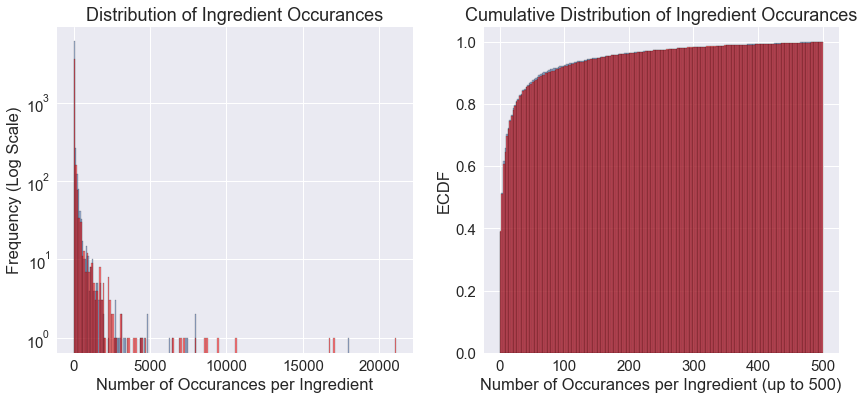

In [426]:
# Create rankings for occurances of ingredients and words
simple_ingredient_rankings = pd.Series(total_ingredients).value_counts()
word_rankings = pd.Series(total_words).value_counts()

# Plot total distribution of ingredient occurences
plt.subplots(figsize=(14,6))
plt.subplot(1, 2, 1)
ingredient_rankings.hist(bins=200, edgecolor='k', alpha=0.5)
simple_ingredient_rankings.hist(bins=200, facecolor='r', edgecolor='k', alpha=0.5)
plt.xlabel('Number of Occurances per Ingredient')
plt.ylabel('Frequency (Log Scale)')
plt.yscale('log')
plt.title('Distribution of Ingredient Occurances')

# Plot ECDF of ingredient occurences
plt.subplot(1, 2, 2)
ingredient_rankings.hist(bins=200, edgecolor='k', cumulative=True, normed=True, range=[0,500], alpha=0.5)
simple_ingredient_rankings.hist(bins=200, facecolor='r', edgecolor='k', cumulative=True, normed=True, range=[0,500], alpha=0.5)
plt.xlabel('Number of Occurances per Ingredient (up to 500)')
plt.ylabel('ECDF')
plt.title('Cumulative Distribution of Ingredient Occurances')

plt.show()

In [326]:
print('Top 10 most common original ingredients:')
print(ingredient_rankings[:20])

print('\nTop 20 most common ingredients (simplified):')
print(simple_ingredient_rankings[:20])

Top 10 most common original ingredients:
salt                   18049
onions                  7972
olive oil               7972
water                   7457
garlic                  7380
sugar                   6434
garlic cloves           6237
butter                  4848
ground black pepper     4785
all-purpose flour       4632
pepper                  4438
vegetable oil           4385
eggs                    3388
soy sauce               3296
kosher salt             3113
green onions            3078
tomatoes                3058
large eggs              2948
carrots                 2814
unsalted butter         2782
dtype: int64

Top 20 most common ingredients (simplified):
salt             21122
pepper           17106
onion            16700
olive oil        10625
garlic            9451
water             8716
sugar             8629
butter            7927
egg               7186
garlic clove      7076
flour             6902
tomato            6477
ginger            4680
soy sauce         447

In [340]:
print('Number of ingredients that appear more than 40 times (0.1% of entries in data): {0}'.format(simple_ingredient_rankings[simple_ingredient_rankings > 40].shape[0]))
print('Number of words that appear more than 40 times (0.1% of entries in data): {0}'.format(word_rankings[word_rankings > 40].shape[0]))

Number of ingredients that appear more than 40 times (0.1% of entries in data): 733
Number of words that appear more than 40 times (0.1% of entries in data): 610


Now that the ingredients have been simplified and consolidated, we can see that the number of ingredients that appear in more than 0.1% of data entries (40 times) is about 700, while the number of words that appear above the same threshold is about 600. We can now move to creating a dataset that holds only these words and ingredients for export.

In [458]:
# Create dataframe to hold only non-outlier values
data_clean = pd.DataFrame(data={'id':data.id,
                                'cuisine': data_simple.cuisine,
                                'ingredients': None,
                                'words': None
                               }, 
                          columns=['id', 'cuisine', 'ingredients', 'words']
                         )

data_clean.head()

,id,cuisine,ingredients,words
0,10259,greek,None,None
1,25693,southern_us,None,None
2,20130,filipino,None,None
3,22213,indian,None,None
4,13162,indian,None,None


In [461]:
# Create lists of ingredients and words for final dataset
final_ingredients = list(simple_ingredient_rankings[(simple_ingredient_rankings > 40) & (simple_ingredient_rankings.index != 'other')].index)
final_words = list(word_rankings[(word_rankings > 40) & (word_rankings.index != 'other')].index)

# Initialize lists to build series and populate columns
ingredients_temp = []
words_temp = []

for i in range(data_simple.shape[0]):
    ingredients_temp.append([ingredient for ingredient in data_simple.ingredients[i] if ingredient in final_ingredients])
    words_temp.append([word for word in data_simple.words[i] if word in final_words])

data_clean.ingredients = ingredients_temp
data_clean.words = words_temp

In [462]:
data_clean.head()

,id,cuisine,ingredients,words
0,10259,greek,"[feta cheese crumbles, olive, grape tomato, on...","[pepper, crumbles, olive, lettuce, tomato, rom..."
1,25693,southern_us,"[corn meal, milk, thyme, flour, salt, tomato, ...","[meal, milk, thyme, vegetable, flour, salt, to..."
2,20130,filipino,"[garlic powder, salt, cooking oil, onion, chic...","[mayonnaise, powder, soy, salt, onion, chicken..."
3,22213,indian,"[water, salt, vegetable oil]","[wheat, vegetable, salt, water, oil]"
4,13162,indian,"[milk, bay leaf, shallot, chili powder, garlic...","[leaf, masala, onion, garam, cayenne, yogurt, ..."


This dataset will be what is used for exploration and analysis, and has the following 4 columns:

**id** - the unique identification number for each recipe  
**cuisine** - the category label of the recipe cuisine  
**ingredients** - a simplified list of ingredients, processed by the steps above (with outliers removed)  
**words** - a list of unique words that appear in the ingredients list (with outliers removed)  

Additionally, since come of the ingredients lists may have been emptied if they only contained non-noun words or symbols, we must removed these rows before exporting our dataset.

In [463]:
# Drop rows that have empty ingredient or word lists
count = 0
for i in data_clean.index:
    if (len(data_clean.words[i]) == 0) | (len(data_clean.ingredients[i]) == 0):
        count += 1
        data_clean.drop(i, axis=0, inplace=True)

print('Number of rows dropped from dataset: {0}'.format(count))

Number of rows dropped from dataset: 17


In [464]:
# display info on new dataset
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39757 entries, 0 to 39773
Data columns (total 4 columns):
id             39757 non-null int64
cuisine        39757 non-null object
ingredients    39757 non-null object
words          39757 non-null object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


Great! Only 17 rows needed to be removed from the dataset, and now it is ready for export. The new dataset will be exported as **data_clean.pkl** to the data folder.

In [465]:
# Set the index of the dataset to be the 'id' column of the dataframe
data_clean = data_clean.set_index('id')
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39757 entries, 10259 to 2362
Data columns (total 3 columns):
cuisine        39757 non-null object
ingredients    39757 non-null object
words          39757 non-null object
dtypes: object(3)
memory usage: 1.2+ MB


In [466]:
# Export dataframe to pickle file for later use
data_clean.to_pickle('data/data_clean.pkl')